In [1]:
# Installation of the requirements
#!python -m pip install -r requirements.txt

In [7]:
'''
(C) Renata Wong 2023

Qiskit code for testing fidelity of derandomised classical shadow on the ground state energy of molecules.

Procedure:
1. Derandomize the molecule-in-question's Hamiltonian.
2. Choose a variational ansatz with initial parameters selected at random.
3. Apply the derandomized Hamiltonian as basis change operators to the ansatz.
4. Measure the ansatz in the Pauli Z basis and store the results as a shadow.
5. Obtain the expectation value of the molecular Hamiltonian from the shadow.
6. Optimize for minimum Hamiltonian expectation value. 
7. Feed the calculated angles/parameters back to the ansatz.
8. Repeat steps 3-7 till the optimization is completed. 
9. Output the minimized expectation value of the molecular Hamiltonian and the mean-square-root-error. 

Note: Below we perform calculations on the molecular Hamiltonian of H_2.
To perform calculations on other molecules, you will need to specify their geometry, charge and spin 
to replace the values in the driver. 
'''

import numpy as np

import time

from qiskit.circuit.library import EfficientSU2
from qiskit_aer import QasmSimulator
from qiskit import QuantumCircuit, execute
from qiskit.algorithms.optimizers import SLSQP
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import BravyiKitaevMapper, QubitConverter
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

from derand.data_acquisition_shadow import derandomized_classical_shadow
from derand.prediction_shadow import estimate_exp





# SPECIFY THE NUMBER OF EXPERIMENTS YOU WANT TO RUN
num_experiments = 1

# SPECIFY THE EXPECTED GROUND STATE ENERGY FOR THE MOLECULE OF INTEREST
EXPECTED_EIGENVALUE = -1.86

# SPECIFY THE GEOMETRY OF THE MOLECULE IN QUESTION
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)


problem = driver.run()
hamiltonian = problem.hamiltonian

# The electronic Hamiltonian of the system
second_q_op = hamiltonian.second_q_op()

# Solving the electronic structure problem = determine the ground state energy of the molecule
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, NumPyMinimumEigensolverFactory
from qiskit_nature.second_q.mappers import BravyiKitaevMapper

# The Bravyi-Kitaev repserentation of the Fermionic Hamiltonian
mapper = BravyiKitaevMapper()
bkenc_hamiltonian = mapper.map(second_q_op)

print(bkenc_hamiltonian)

-0.8105479805373234 * IIII
+ 0.1721839326191557 * IIIZ
- 0.2257534922240249 * IIZZ
+ 0.1721839326191554 * IZII
- 0.22575349222402488 * ZZZI
+ 0.1209126326177664 * IIZI
+ 0.1689275387008791 * IZIZ
+ 0.04523279994605785 * ZXIX
- 0.04523279994605785 * IXZX
- 0.04523279994605785 * ZXZX
+ 0.04523279994605785 * IXIX
+ 0.1661454325638242 * ZZZZ
+ 0.16614543256382422 * IZZZ
+ 0.1746434306830045 * ZZIZ
+ 0.1209126326177664 * ZIZI


In [8]:
'''
Format Hamiltonian terms and coefficients as required by the package predicting-quantum-properties
'''

hamiltonian_terms = []
weights = []

for observable in bkenc_hamiltonian:
    
    observable_str = str(observable)
    observable_str_clean = observable_str.strip()  # removes white spaces
    pauli_str_list = observable_str_clean.split('*')
    tuple_list = []
    
    for op_index, pauli_op in enumerate(pauli_str_list[1]):
        if pauli_op == 'I' or pauli_op == 'X' or pauli_op == 'Y' or pauli_op == 'Z':
            tuple_list.append((pauli_op, op_index-1))
    if len(tuple_list) > 0:
        hamiltonian_terms.append(tuple_list)
        weights.append(float(pauli_str_list[0].strip()))

system_size = len(hamiltonian_terms[0])

print(hamiltonian_terms)
print(weights)







'''
Reformatting the Hamiltonian for use in estimate_exp(): removing all entries with Pauli I. 
'''

hamiltonian_terms_XYZ = []

for term in hamiltonian_terms:
    term_XYZ = []
    for pauli in term:
        if pauli[0] != 'I':
            term_XYZ.append(pauli)
    hamiltonian_terms_XYZ.append(term_XYZ)         
    
print(hamiltonian_terms_XYZ)

[[('I', 0), ('I', 1), ('I', 2), ('I', 3)], [('I', 0), ('I', 1), ('I', 2), ('Z', 3)], [('I', 0), ('I', 1), ('Z', 2), ('Z', 3)], [('I', 0), ('Z', 1), ('I', 2), ('I', 3)], [('Z', 0), ('Z', 1), ('Z', 2), ('I', 3)], [('I', 0), ('I', 1), ('Z', 2), ('I', 3)], [('I', 0), ('Z', 1), ('I', 2), ('Z', 3)], [('Z', 0), ('X', 1), ('I', 2), ('X', 3)], [('I', 0), ('X', 1), ('Z', 2), ('X', 3)], [('Z', 0), ('X', 1), ('Z', 2), ('X', 3)], [('I', 0), ('X', 1), ('I', 2), ('X', 3)], [('Z', 0), ('Z', 1), ('Z', 2), ('Z', 3)], [('I', 0), ('Z', 1), ('Z', 2), ('Z', 3)], [('Z', 0), ('Z', 1), ('I', 2), ('Z', 3)], [('Z', 0), ('I', 1), ('Z', 2), ('I', 3)]]
[-0.8105479805373234, 0.1721839326191557, -0.2257534922240249, 0.1721839326191554, -0.22575349222402488, 0.1209126326177664, 0.1689275387008791, 0.04523279994605785, -0.04523279994605785, -0.04523279994605785, 0.04523279994605785, 0.1661454325638242, 0.16614543256382422, 0.1746434306830045, 0.1209126326177664]
[[], [('Z', 3)], [('Z', 2), ('Z', 3)], [('Z', 1)], [('Z',

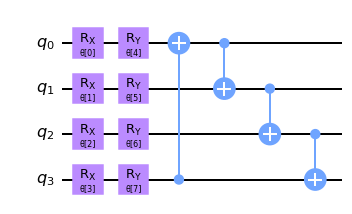

In [9]:
'''
Choose a variational ansatz.
Note that for molecules other than H_2 you may need to specify a different number of reps.
'''

reps = 1   
ansatz = EfficientSU2(4, su2_gates=['rx', 'ry'], entanglement='circular', reps=reps, skip_final_rotation_layer=True)  
    
ansatz.decompose().draw('mpl')

In [10]:
'''
Generate derandomized Hamiltonian
'''

num_obs_evals = 67    

derandomized_hamiltonian = derandomized_classical_shadow(hamiltonian_terms, 
                                                                num_obs_evals, system_size, weight=weights)

print(derandomized_hamiltonian)

[['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X', 'X', 'X'], ['Z', 'X'

In [11]:
'''
Define the cost function
'''

backend = QasmSimulator(method='statevector', shots=1)


# Create circuit with just the randomised basis change operators
def rand_meas_circuit(pauli_op):
    rand_meas = QuantumCircuit(ansatz.num_qubits)
    for idx, op in enumerate(pauli_op):
        if op == 'X':
            rand_meas.x(idx)
        elif op == 'Y':
            rand_meas.y(idx)
        elif op == 'Z':
            rand_meas.z(idx)
    return rand_meas


def objective_function(params):
    
    # Assign parameters to the ansatz and simulate it
    # Generate circuits to measure random Paulis, one circuit for each Pauli
    
    shadow = []
    for pauli_op in derandomized_hamiltonian:
        qc = ansatz.bind_parameters(params)
        qc.compose(rand_meas_circuit(pauli_op))
        qc.measure_all()
        result = execute(qc, backend, shots=1).result()
        counts = result.get_counts()
        
        
        # We perform one single shot => index(1)
        # store the shadow in the form [[(Z,1),(Z,-1)...], [(Y,-1),(X,-1),...]] where inner list = snapshot
        # Because measurement output in Qiskit gives us states and not eigenvalues, we need to convert 0->1 and 1->-1
        
        output_str = list(list(counts.keys())[list(counts.values()).index(1)])
        output = [int(i) for i in output_str]
        eigenvals = [x+1 if x == 0 else x-2 for x in output]
        snapshot = [(op, eigenval) for op, eigenval in zip(pauli_op, eigenvals)]
        shadow.append(snapshot)
    
    
    # Now, we want to get the expectation values for the Hamiltonian from the shadow using the function
    # estimate_exp(full_measurement, one_observable)
    # where full_measurement = shadow and one_observable is any term in the Hamiltonian with I observable excluded.
    # cost = the total expectation value of the Hamiltonian
    # NOTE: We need to check for match_count value since it may happen that it is equal to 0. 
    # Such experiments need to be excluded. 
    # The problem is due to the derandomization algorithm not always producing Paulis that 'hit' the Hamiltonian terms.
    
    cost = 0.0
    for term, weight in zip(hamiltonian_terms_XYZ, weights):
        sum_product, match_count = estimate_exp(shadow, term)
        if match_count != 0:
            exp_val = weight * (sum_product / match_count)
            cost = cost + exp_val
    
    return cost


In [12]:
'''
Classical optimisation step
'''

# Counter for the execution time
start_time = time.time()


# Classical optimizer
optimizer = SLSQP(maxiter=500)   


# how many experiments to perform
num_experiments = 1

# Collect the expectation value from each experiment
expectation_values = []


for _ in range(num_experiments):

    params = np.random.rand(ansatz.num_parameters)
    result = optimizer.minimize(fun=objective_function, x0=params)
    expectation_values.append(result.fun)
    print("GROUND STATE ENERGY FOUND = ", result.fun)


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

GROUND STATE ENERGY FOUND =  -0.7585190086590717
Execution time =  02:08:33


In [13]:
'''
Calculate the error.
'''

rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 for i in range(num_experiments)]))
print(f"The average root-mean-squared error for derandomized classical shadow: {rmse_derandomised_cs}")


The average root-mean-squared error for derandomized classical shadow: 1.1014809913409285


In [ ]:
'''
Above we have assumed a particular ground state energy for the molecule of interest.
Below we corroborate this assumption using a classical minimum eigensolver on our Hamiltonian.
'''

converter = QubitConverter(BravyiKitaevMapper())
numpy_solver = NumPyMinimumEigensolver()   

calc = GroundStateEigensolver(converter, numpy_solver)
res = calc.solve(problem)
print('Electronic ground state energy:\n', res) 

In [ ]:
'''
Reconstructing the experimental results in https://arxiv.org/abs/2103.07510

Note: Depending on the value specified in the variable num_obs_evals, we are bound to get different results
      as derandomization will generate varying derandomized operators. 
      
      E.g. for num_obs_evals = 7, the generated operators are ('Z', 'Z', 'X', 'X') and ('Z', 'Z', 'Z', 'Z'), which 
      overlap with most of the terms in the Hamiltonian. 
      For num_obs_evals = 7, we find the following: ground state energy = -1.6401863539239494
                                                    error = 0.2198136460760507
                                                        
      For num_obs_evals = 23, the generated operator is ('Z', 'X', 'X', 'X'), which overlaps with only 2 terms in the 
      Hamiltonian. Here, ground state energy = 
                         error = 
                         

   GROUND STATE ENERGIES and ERRORS for 10 experiments at 1005 measurements (runtime: ca. 1h30m per experiment):
1. -0.8160389273964469       1.0439610726035533
2. -0.8020865214429365       1.0579134785570636
3. -0.7585190086590717       1.1014809913409285
4. 
5. 
6. 
7. 
8. 
9. 
10.

Average error over 10 experiments: 
'''

In [20]:
'''
Manually generate two measurements: ZZZZ and ZXZX, which together overlap with the entire Hamiltonian. 
'''
man_gen_derand_hamiltonian = [['Z', 'Z', 'Z', 'Z'], ['Z', 'Z', 'Z', 'Z'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X']]

print(man_gen_derand_hamiltonian)


[['Z', 'Z', 'Z', 'Z'], ['Z', 'Z', 'Z', 'Z'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X', 'Z', 'X'], ['Z', 'X'

In [21]:
def objective_function(params):
    
    shadow = []
    for pauli_op in man_gen_derand_hamiltonian[0:99]:
        qc = ansatz.bind_parameters(params)
        qc.compose(rand_meas_circuit(pauli_op))
        qc.measure_all()
        result = execute(qc, backend, shots=1).result()
        counts = result.get_counts()
        
        output_str = list(list(counts.keys())[list(counts.values()).index(1)])
        output = [int(i) for i in output_str]
        eigenvals = [x+1 if x == 0 else x-2 for x in output]
        snapshot = [(op, eigenval) for op, eigenval in zip(pauli_op, eigenvals)]
        shadow.append(snapshot)
    
    cost = 0.0
    for term, weight in zip(hamiltonian_terms_XYZ, weights):
        if len(term) == 0:
            cost = cost + weight
        sum_product, match_count = estimate_exp(shadow, term)
        if match_count != 0:
            exp_val = weight * (sum_product / match_count)
            cost = cost + exp_val
    
    return cost



# Counter for the execution time
start_time = time.time()


# Classical optimizer
optimizer = SLSQP(maxiter=500)   


# how many experiments to perform
num_experiments = 1

# Collect the expectation value from each experiment
expectation_values = []


for _ in range(num_experiments):

    params = np.random.rand(ansatz.num_parameters)
    result = optimizer.minimize(fun=objective_function, x0=params)
    expectation_values.append(result.fun)
    print("GROUND STATE ENERGY FOUND = ", result.fun)


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 for i in range(num_experiments)]))
print(f"The average root-mean-squared error for derandomized classical shadow: {rmse_derandomised_cs}")


GROUND STATE ENERGY FOUND =  -1.6407258803002598
Execution time =  00:11:59
The average root-mean-squared error for derandomized classical shadow: 0.2192741196997403


In [14]:
'''
It is difficult to specify a number of minimum evaluations per observable that would generate a derandomization scheme covering 
the original Hamiltonian observables well. For that reason, we generate some statistics to check for possible patterns
in generating good derandomizations. 
This is only a helper function, not to be treated as part of the algorithm.
'''
from collections import Counter


for num_obs_evals in range(1, 200):

    derandomized_hamiltonians = derandomized_classical_shadow(hamiltonian_terms, 
                                                                num_obs_evals, system_size, weight=weights)
    tuples = (tuple(pauli) for pauli in derandomized_hamiltonians)
    counts = Counter(tuples)
        
    print(f'NUM_EVALS =', num_obs_evals, 'DERAND_OBS =', counts)

NUM_EVALS = 1 DERAND_OBS = Counter({('X', 'X', 'X', 'X'): 1})
NUM_EVALS = 2 DERAND_OBS = Counter({('X', 'X', 'X', 'X'): 1})
NUM_EVALS = 3 DERAND_OBS = Counter({('X', 'X', 'X', 'X'): 1})
NUM_EVALS = 4 DERAND_OBS = Counter({('X', 'X', 'X', 'X'): 1})
NUM_EVALS = 5 DERAND_OBS = Counter({('X', 'X', 'X', 'X'): 1})
NUM_EVALS = 6 DERAND_OBS = Counter({('Z', 'Z', 'X', 'X'): 90})
NUM_EVALS = 7 DERAND_OBS = Counter({('Z', 'Z', 'X', 'X'): 104, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_EVALS = 8 DERAND_OBS = Counter({('Z', 'Z', 'X', 'X'): 119, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_EVALS = 9 DERAND_OBS = Counter({('Z', 'Z', 'X', 'X'): 134, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_EVALS = 10 DERAND_OBS = Counter({('Z', 'Z', 'X', 'X'): 149, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_EVALS = 11 DERAND_OBS = Counter({('Z', 'Z', 'X', 'X'): 164, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_EVALS = 12 DERAND_OBS = Counter({('Z', 'Z', 'X', 'X'): 179, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_EVALS = 13 DERAND_OBS = Counter({('Z', 'Z', 'X', 'X'): 193, ('Z', 'Z', 'Z', 'Z'): 2})


NUM_EVALS = 121 DERAND_OBS = Counter({('Z', 'X', 'X', 'X'): 1815})
NUM_EVALS = 122 DERAND_OBS = Counter({('Z', 'X', 'X', 'X'): 1830})
NUM_EVALS = 123 DERAND_OBS = Counter({('Z', 'X', 'X', 'X'): 1845})
NUM_EVALS = 124 DERAND_OBS = Counter({('Z', 'X', 'X', 'X'): 1860})
NUM_EVALS = 125 DERAND_OBS = Counter({('Z', 'X', 'X', 'X'): 1875})
NUM_EVALS = 126 DERAND_OBS = Counter({('Z', 'X', 'X', 'X'): 1890})
NUM_EVALS = 127 DERAND_OBS = Counter({('Z', 'X', 'X', 'X'): 1905})
NUM_EVALS = 128 DERAND_OBS = Counter({('Z', 'X', 'X', 'X'): 1920})
NUM_EVALS = 129 DERAND_OBS = Counter({('Z', 'X', 'X', 'X'): 1935})
NUM_EVALS = 130 DERAND_OBS = Counter({('Z', 'X', 'X', 'X'): 1950})
NUM_EVALS = 131 DERAND_OBS = Counter({('Z', 'X', 'X', 'X'): 1965})
NUM_EVALS = 132 DERAND_OBS = Counter({('Z', 'X', 'X', 'X'): 1980})
NUM_EVALS = 133 DERAND_OBS = Counter({('Z', 'X', 'X', 'X'): 1995})
NUM_EVALS = 134 DERAND_OBS = Counter({('Z', 'X', 'X', 'X'): 2010})
NUM_EVALS = 135 DERAND_OBS = Counter({('Z', 'X', 'X', 'X'): 20